In [32]:
import tvm
from tvm.script import tir as T
from tvm.script import relax as R
from tvm import relay
from tvm import relax, topi
import numpy as np
import IPython

In [134]:
@tvm.script.ir_module
class MNIST:
    @T.prim_func
    def div255(X: T.Buffer((1,1,28,28), "float32"),
               Y: T.Buffer((28,28), "float32")):
        for i, j in T.grid(28,28):
            with T.block("Y"):
                vi, vj = T.axis.remap("SS", (i,j))
                Y[vi, vj] = X[0,0,vi, vj] * T.float32(1/255)

    @T.prim_func
    def Conv2DRelu_1(X: T.Buffer((28,28),"float32"),
                     W: T.Buffer((8, 1, 5, 5), "float32"),
                     B: T.Buffer((8,), "float32"),
                     Y: T.Buffer((8, 28, 28), "float32")):
        padded = T.alloc_buffer((32,32), "float32")
        A = T.alloc_buffer((8,28,28), "float32")
        for i, j in T.grid(32, 32):
            with T.block("pad_init"):
                vi, vj = T.axis.remap("SS", [i, j])
                padded[vi, vj] = 0
        for i, j in T.grid(28, 28):
            with T.block("copy"):
                vi, vj = T.axis.remap("SS", [i, j])
                padded[vi+2, vj+2] = X[vi, vj]
        for q, i, j, di, dj in T.grid(8, 28, 28, 5, 5):
            with T.block("conv"):
                vq, vi, vj, vdi, vdj = T.axis.remap("SSSRR", [q, i, j, di, dj])
                with T.init():
                    A[vq, vi, vj] = 0
                A[vq, vi, vj] += padded[vi+vdi, vj+vdj] * W[vq, 0, vdi, vdj]
        for q, i, j in T.grid(8, 28, 28):
            with T.block("biasrelu"):
                vq, vi, vj = T.axis.remap("SSS", [q, i, j])
                Y[vq, vi, vj] = T.max(A[vq, vi, vj] + B[vq], 0)

    @T.prim_func
    def MaxPooling2D_1(X: T.Buffer((8, 28, 28), "float32"),
                       Y: T.Buffer((8, 14,14), "float32")):
        for q, i, j in T.grid(8, 14, 14):
            with T.block("Y"):
                vq, vi, vj = T.axis.remap("SSS", [q,i,j])
                Y[vq, vi, vj] = T.max(T.max(X[vq, 2*vi, 2*vj], X[vq, 2*vi, 2*vj+1]), T.max(X[vq, 2*vi+1, 2*vj], X[vq, 2*vi+1, 2*vj+1]))

    @T.prim_func
    def Conv2DRelu_2(X: T.Buffer((8, 14, 14),"float32"),
                     W: T.Buffer((16, 8, 5, 5), "float32"),
                     B: T.Buffer((16,), "float32"),
                     Y: T.Buffer((16, 14, 14), "float32")):
        padded = T.alloc_buffer((8,20,20), "float32")
        A = T.alloc_buffer((16,14,14),"float32")
        for k, i, j in T.grid(8, 20, 20):
            with T.block("pad_init"):
                vk, vi, vj = T.axis.remap("SSS", [k, i, j])
                padded[vk, vi, vj] = 0
        for k, i, j in T.grid(8, 14, 14):
            with T.block("copy"):
                vk, vi, vj = T.axis.remap("SSS", [k, i, j])
                padded[vk, vi+2, vj+2] = X[vk, vi, vj]
        for k, q, i, j, di, dj in T.grid(16, 8, 14, 14, 5, 5):
            with T.block("conv"):
                vq, vi, vj, vk, vdi, vdj = T.axis.remap("SSSRRR", [q, i, j, k, di, dj])
                with T.init():
                    A[vq, vi, vj] = 0
                A[vq, vi, vj] += padded[vk, vi+vdi, vj+vdj] * W[vq, vk, vdi, vdj]
        for q, i, j in T.grid(16, 14, 14):
            with T.block("biasrelu"):
                vq, vi, vj = T.axis.remap("SSS", [q, i, j])
                Y[vq, vi, vj] = T.max(A[vq, vi, vj] + B[vq], 0)

    @T.prim_func
    def MaxPooling2D_2(X: T.Buffer((16, 14, 14), "float32"),
                       Y: T.Buffer((16, 4, 4), "float32")):
        for q, i, j, di, dj in T.grid(16, 4, 4, 3, 3):
            with T.block("Y"):
                vq, vi, vj, vdi, vdj = T.axis.remap("SSSSS", [q, i, j, di, dj])
                with T.init():
                    Y[vq, vi, vj] = 0
                Y[vq, vi, vj] = T.max(Y[vq, vi, vj], X[vq, 3*vi+vdi, 3*vj+vdj])

    @T.prim_func
    def Dense(X: T.Buffer((16, 4, 4), "float32"),
              W: T.Buffer((10, 256), "float32"),
              B: T.Buffer((10,), "float32"),
              Y: T.Buffer((10,), "float32")):
        temp = T.alloc_buffer((10), "float32")
        for i, k1, k2, k3 in T.grid(10, 16, 4, 4):
            with T.block("mul"):
                vi, vk1, vk2, vk3 = T.axis.remap("SRRR", [i, k1, k2, k3])
                with T.init():
                    temp[vi] = 0
                temp[vi] = temp[vi] + X[vk1, vk2, vk3]*W[vi, 16*vk1+4*vk2+vk3]
        for i in range(10):
            with T.block("bias"):
                vi = T.axis.spatial(10, i)
                Y[vi] = temp[vi] + B[vi]

    @R.function
    def main(x: R.Tensor((1, 1, 28, 28), "float32"),
             w0: R.Tensor((8, 1, 5, 5), "float32"),
             b0: R.Tensor((8,), "float32"),
             w1: R.Tensor((16, 8, 5, 5), "float32"),
             b1: R.Tensor((16,), "float32"),
             w2: R.Tensor((10, 256), "float32"),
             b2: R.Tensor((10,), "float32")
             ):
        with R.dataflow():
            lv0 = R.call_dps_packed("div255", (x, ), R.Tensor((28, 28), "float32"))
            lv1 = R.call_dps_packed("Conv2DRelu_1", (lv0, w0, b0), R.Tensor((8, 28, 28), "float32"))
            lv2 = R.call_dps_packed("MaxPooling2D_1", (lv1, ), R.Tensor((8, 14, 14), "float32"))
            lv3 = R.call_dps_packed("Conv2DRelu_2", (lv2, w1, b1), R.Tensor((16, 14, 14), "float32"))
            lv4 = R.call_dps_packed("MaxPooling2D_2", (lv3, ), R.Tensor((16, 4, 4), "float32"))
            out = R.call_dps_packed("Dense", (lv4, w2, b2), R.Tensor((10,), "float32"))
            R.output(out)
        return out

In [135]:
sch=tvm.tir.Schedule(MNIST)
IPython.display.Code(sch.mod.script(), language="python")

# from tvm.script import ir as I
# from tvm.script import tir as T
# from tvm.script import relax as R

@I.ir_module
class Module:
    @T.prim_func
    def Conv2DRelu_1(X: T.Buffer((28, 28), "float32"), W: T.Buffer((8, 1, 5, 5), "float32"), B: T.Buffer((8,), "float32"), Y: T.Buffer((8, 28, 28), "float32")):
        # with T.block("root"):
        padded = T.alloc_buffer((32, 32))
        A = T.alloc_buffer((8, 28, 28))
        for i, j in T.grid(32, 32):
            with T.block("pad_init"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads()
                T.writes(padded[vi, vj])
                padded[vi, vj] = T.float32(0.0)
        for i, j in T.grid(28, 28):
            with T.block("copy"):
                vi, vj = T.axis.remap("SS", [i, j])
                T.reads(X[vi, vj])
                T.writes(padded[vi + 2, vj + 2])
                padded[vi + 2, vj + 2] = X[vi, vj]
        for q, i, j, di, dj in T.grid(8, 28, 28, 5, 5):
            with T.block("conv"):
                vq, vi, vj, vdi, vdj = T.axis.remap("SSSRR", [q, i, j, di, dj])
                T.reads(padded[vi + vdi, vj + vdj], W[vq, 0, vdi, vdj])
                T.writes(A[vq, vi, vj])
                with T.init():
                    A[vq, vi, vj] = T.float32(0.0)
                A[vq, vi, vj] = A[vq, vi, vj] + padded[vi + vdi, vj + vdj] * W[vq, 0, vdi, vdj]
        for q, i, j in T.grid(8, 28, 28):
            with T.block("biasrelu"):
                vq, vi, vj = T.axis.remap("SSS", [q, i, j])
                T.reads(A[vq, vi, vj], B[vq])
                T.writes(Y[vq, vi, vj])
                Y[vq, vi, vj] = T.max(A[vq, vi, vj] + B[vq], T.float32(0.0))

    @T.prim_func
    def Conv2DRelu_2(X: T.Buffer((8, 14, 14), "float32"), W: T.Buffer((16, 8, 5, 5), "float32"), B: T.Buffer((16,), "float32"), Y: T.Buffer((16, 14, 14), "float32")):
        # with T.block("root"):
        padded = T.alloc_buffer((8, 20, 20))
        A = T.alloc_buffer((16, 14, 14))
        for k, i, j in T.grid(8, 20, 20):
            with T.block("pad_init"):
                vk, vi, vj = T.axis.remap("SSS", [k, i, j])
                T.reads()
                T.writes(padded[vk, vi, vj])
                padded[vk, vi, vj] = T.float32(0.0)
        for k, i, j in T.grid(8, 14, 14):
            with T.block("copy"):
                vk, vi, vj = T.axis.remap("SSS", [k, i, j])
                T.reads(X[vk, vi, vj])
                T.writes(padded[vk, vi + 2, vj + 2])
                padded[vk, vi + 2, vj + 2] = X[vk, vi, vj]
        for k, q, i, j, di, dj in T.grid(16, 8, 14, 14, 5, 5):
            with T.block("conv"):
                vq, vi, vj, vk, vdi, vdj = T.axis.remap("SSSRRR", [q, i, j, k, di, dj])
                T.reads(padded[vk, vi + vdi, vj + vdj], W[vq, vk, vdi, vdj])
                T.writes(A[vq, vi, vj])
                with T.init():
                    A[vq, vi, vj] = T.float32(0.0)
                A[vq, vi, vj] = A[vq, vi, vj] + padded[vk, vi + vdi, vj + vdj] * W[vq, vk, vdi, vdj]
        for q, i, j in T.grid(16, 14, 14):
            with T.block("biasrelu"):
                vq, vi, vj = T.axis.remap("SSS", [q, i, j])
                T.reads(A[vq, vi, vj], B[vq])
                T.writes(Y[vq, vi, vj])
                Y[vq, vi, vj] = T.max(A[vq, vi, vj] + B[vq], T.float32(0.0))

    @T.prim_func
    def Dense(X: T.Buffer((16, 4, 4), "float32"), W: T.Buffer((10, 256), "float32"), B: T.Buffer((10,), "float32"), Y: T.Buffer((10,), "float32")):
        # with T.block("root"):
        temp = T.alloc_buffer((10,))
        for i, k1, k2, k3 in T.grid(10, 16, 4, 4):
            with T.block("mul"):
                vi, vk1, vk2, vk3 = T.axis.remap("SRRR", [i, k1, k2, k3])
                T.reads(X[vk1, vk2, vk3], W[vi, 16 * vk1 + 4 * vk2 + vk3])
                T.writes(temp[vi])
                with T.init():
                    temp[vi] = T.float32(0.0)
                temp[vi] = temp[vi] + X[vk1, vk2, vk3] * W[vi, 16 * vk1 + 4 * vk2 + vk3]
     

In [114]:
import os
import onnx

onnx_model = onnx.load("mnist/mnist-8.onnx")

mod, params = relay.frontend.from_onnx(onnx_model, {"Input3": (1,1,28,28)})

(16, 4, 4, 10)
(16, 8, 5, 5)
(8, 1, 5, 5)
(8, 1, 1)
(16, 1, 1)
(2,)
(2,)
(1, 10)


In [136]:
weights = []
for initializer in onnx_model.graph.initializer:
    weights.append(onnx.numpy_helper.to_array(initializer))

for w in weights:
    print(w.shape)

weights[0] = weights[0].reshape((256,10)).transpose()
weights[3] = weights[3].reshape((8,))
weights[4] = weights[4].reshape((16,))
weights[7] = weights[7].reshape((10,))

params = [weights[2], weights[3], weights[1], weights[4], weights[0], weights[7]]

params = [tvm.nd.array(w, device=tvm.cpu()) for w in params]

(16, 4, 4, 10)
(16, 8, 5, 5)
(8, 1, 5, 5)
(8, 1, 1)
(16, 1, 1)
(2,)
(2,)
(1, 10)


In [137]:
ex = relax.build(MNIST, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=True)

[-0.00457341  0.16657507 -0.40194058 -0.21732956  0.14365725  0.3357103
 -0.51385933  0.09719408 -0.23806621  0.14697815]


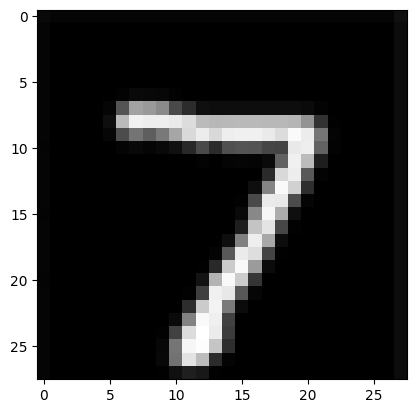

In [138]:
from PIL import Image
import matplotlib.pyplot as plt
from tvm.contrib.download import download_testdata

# This is clearly not a MNIST image, but whatever
#img_url = "https://www.researchgate.net/publication/321174607/figure/fig3/AS:806993333850113@1569413612260/Example-of-a-MNIST-input-An-image-is-passed-to-the-network-as-a-matrix-of-28-by-28.png"
#img_path = download_testdata(img_url, "mnist.png", module="data")
img = Image.open("seven.png").resize((28, 28)) #.resize((416, 416))
plt.imshow(img)
img_ycbcr = img.convert("YCbCr")  # convert to YCbCr
img_y, img_cb, img_cr = img_ycbcr.split()
x = np.array(img_y)[np.newaxis, np.newaxis, :, :]
tvm_x = tvm.nd.array(x.astype("float32"), device=tvm.cpu())
print(vm["main"](tvm_x, *params).numpy())

In [39]:
sch = tvm.tir.Schedule(MNIST)

conv = sch.get_block("conv", func_name="Conv2DRelu_1")
k, i, j, di, dj = sch.get_loops(conv)

#sch.reorder(k, i, j, di, dj)

sch.parallel(k)
sch.unroll(di)
sch.vectorize(dj)


conv2 = sch.get_block("conv", func_name="Conv2DRelu_2")
k, i, j, q, di, dj = sch.get_loops(conv2)

sch.reorder(q, k, i, j, di, dj)

sch.parallel(q)
sch.unroll(di)
sch.vectorize(dj)


matmul = sch.get_block("mul", func_name="Dense")
i, k1, k2, k3 = sch.get_loops(matmul)
sch.reorder(k1,i, k2, k3)


In [40]:
ex = relax.build(MNIST, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=True)
evaluator = vm.profile("main",
    tvm_x, *params
)
evaluator

Name                          Duration (us)  Percent  Device  Count                                                                   Argument Shapes  
Conv2DRelu_2                         333,00    66.82    cpu0      1  float32[8, 14, 14], float32[16, 8, 5, 5], float32[16, 1, 1], float32[16, 14, 14]  
Conv2DRelu_1                          10,81     2.17    cpu0      1        float32[28, 28], float32[8, 1, 5, 5], float32[8, 1, 1], float32[8, 28, 28]  
Dense                                  5,39     1.08    cpu0      1                  float32[16, 4, 4], float32[10, 256], float32[1, 10], float32[10]  
MaxPooling2D_1                         4,35     0.87    cpu0      1                                            float32[8, 28, 28], float32[8, 14, 14]  
vm.builtin.check_tensor_info           2,10     0.42    cpu0      1                                                             float32[1, 1, 28, 28]  
div255                                 1,66     0.33    cpu0      1                     

In [41]:
ex = relax.build(sch.mod, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=True)
evaluator = vm.profile("main",
    tvm_x, *params
)
evaluator

Name                          Duration (us)  Percent  Device  Count                                                                   Argument Shapes  
Conv2DRelu_2                         327,32    66.34    cpu0      1  float32[8, 14, 14], float32[16, 8, 5, 5], float32[16, 1, 1], float32[16, 14, 14]  
Conv2DRelu_1                          15,20     3.08    cpu0      1        float32[28, 28], float32[8, 1, 5, 5], float32[8, 1, 1], float32[8, 28, 28]  
MaxPooling2D_1                         4,69     0.95    cpu0      1                                            float32[8, 28, 28], float32[8, 14, 14]  
Dense                                  3,85     0.78    cpu0      1                  float32[16, 4, 4], float32[10, 256], float32[1, 10], float32[10]  
vm.builtin.check_tensor_info           2,13     0.43    cpu0      1                                                             float32[1, 1, 28, 28]  
vm.builtin.check_tensor_info           1,62     0.33    cpu0      1                     

In [129]:
ex = relax.build(sch.mod, target="llvm", pipeline="default_build")  # You can try 'default_build'
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=False)
evaluator = vm.time_evaluator("main", dev=tvm.cpu(), min_repeat_ms=200)(
    tvm_x, *params
)
evaluator

BenchmarkResult(min=0.000361029927756654, mean=0.000361029927756654, median=0.000361029927756654, max=0.000361029927756654, std=0.0, results=(0.000361029927756654,))

In [128]:
ex = relax.build(MNIST, target="llvm", pipeline="default_build")  # You can try 'default_build'
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=False)
evaluator = vm.time_evaluator("main", dev=tvm.cpu(), min_repeat_ms=200)(
    tvm_x, *params
)
evaluator

BenchmarkResult(min=0.0003697487570694087, mean=0.0003697487570694087, median=0.0003697487570694087, max=0.0003697487570694087, std=0.0, results=(0.0003697487570694087,))

In [123]:
class MyRelaxModel(relax.frontend.nn.Module):
    def __init__(self):
        super(MyRelaxModel, self).__init__()
        self.conv1 = relax.frontend.nn.Conv2D(1, 8, kernel_size=5, stride=1, padding=2, bias=True)
        self.relu1 = relax.frontend.nn.ReLU()
        self.conv2 = relax.frontend.nn.Conv2D(8, 16, kernel_size=5, stride=1, padding=2, bias=True)
        self.relu2 = relax.frontend.nn.ReLU()
        self.dense = relax.frontend.nn.Linear(256, 10)

    def forward(self, x):
        x = x/255
        x = self.conv1(x)
        x = self.relu1(x)
        x = tvm.relax.frontend.nn.tensor_expr_op(topi.nn.pool2d, "max_pool2d", [x, (2,2), (2,2), (1,1), (0,0,0,0), "max"])
        x = self.conv2(x)
        x = self.relu2(x)
        x = tvm.relax.frontend.nn.tensor_expr_op(topi.nn.pool2d, "max_pool2d", [x, (3,3), (3,3), (1,1), (0,0,0,0), "max"])
        x = tvm.relax.frontend.nn.tensor_expr_op(topi.nn.flatten, "flatten", [x])
        x = self.dense(x)
        return x



input_shape = (1, 1, 28, 28)
mod, params_ = MyRelaxModel().export_tvm({"forward": {"x": relax.frontend.nn.spec.Tensor(input_shape, "float32")}})

# Unlike in torch, model parameters are not initialized automatically. Let's create them by hand
# We'll need them at profile time
model_params_tvm = [tvm.nd.array(np.random.randn(*x[1].shape).astype(np.float32)) for x in params_]
model_params_tvm_labels = [x[0] for x in params_]

mod.show()

In [124]:

mod = relax.transform.LegalizeOps()(mod)

In [130]:
ex = relax.build(mod, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=True)
vm["forward"](tvm_x, *params)

<tvm.nd.NDArray shape=(1, 10), cpu(0)>
array([[ -1.4030411 ,   0.56343764,   7.8122272 ,   8.211108  ,
        -12.606699  ,  -5.151139  , -21.856295  ,  26.215685  ,
         -6.422785  ,   3.6129267 ]], dtype=float32)

In [122]:

ex = relax.build(mod, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu(), profile=True)
evaluator = vm.profile("forward",
    tvm_x, *params
)
evaluator

ValueError: Traceback (most recent call last):
  2: tvm::runtime::relax_vm::VirtualMachineProfiler::GetFunction(tvm::runtime::String const&, tvm::runtime::ObjectPtr<tvm::runtime::Object> const&)::{lambda(tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*)#1}::operator()(tvm::runtime::TVMArgs, tvm::runtime::TVMRetValue*) const
  1: tvm::runtime::relax_vm::VirtualMachineImpl::GetClosureInternal(tvm::runtime::String const&, bool)
  0: _ZN3tvm7runtime6deta
  File "/home/gael/tvm/src/runtime/relax_vm/vm.cc", line 616
ValueError: Unknown function: forward

In [71]:
mod = relax.transform.MetaScheduleTuneTIR(work_dir="./tune_tmp", max_trials_global=64)(mod)

TypeError: MetaScheduleTuneTIR() got an unexpected keyword argument 'target'